<a href="https://colab.research.google.com/github/TungerPunch/Simpson_classification/blob/main/simpsons_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Установка зависимостей

In [1]:
!pip install -U torch torchvision
!pip install kaggle

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
from os.path import exists
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
!pip install Pillow

In [4]:
import PIL
#print(PIL.PILLOW_VERSION)
print(PIL.__version__)


9.4.0


In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahmatullinaydar","key":"d017843a00a76e793f4ffdf1af67f705"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle competitions download -c journey-springfield

100% 519M/521M [00:29<00:00, 19.5MB/s]
100% 521M/521M [00:29<00:00, 18.2MB/s]


In [8]:
!unzip -q /content/journey-springfield.zip

In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Sep  8 09:11:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
import pickle
import numpy as np
from skimage import io

from time import time
from tqdm import tqdm, tqdm_notebook, trange
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


The total number of images: 20933
[3, 8, 8, 17, 27, 27, 32, 40, 42, 45, 47, 55, 65, 71, 72, 89, 98, 103, 106, 121, 128, 181, 246, 310, 358, 457, 469, 498, 623, 877, 913, 986, 1079, 1193, 1194, 1206, 1291, 1342, 1354, 1452, 1454, 2246]


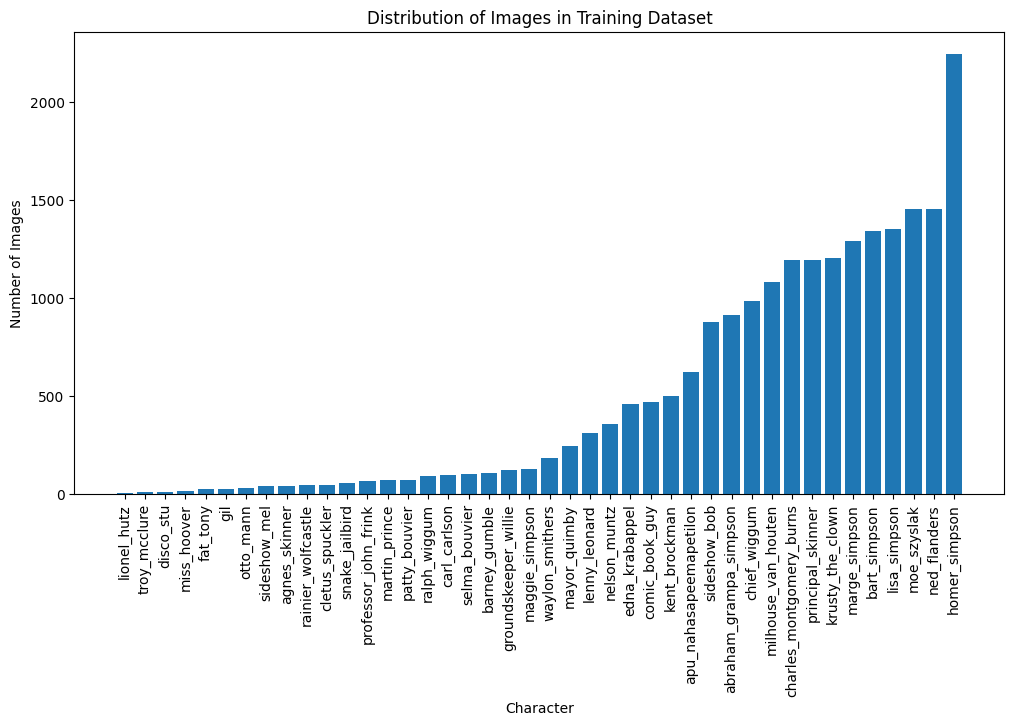

In [8]:
import os
import matplotlib.pyplot as plt

def get_class_distribution(dataset_folder):
    class_counts = {}
    total_images = 0
    for class_name in os.listdir(dataset_folder):
        class_path = os.path.join(dataset_folder, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images
    return class_counts, total_images

training_folder = '/content/train/simpsons_dataset'
class_distribution, total_images = get_class_distribution(training_folder)

print("The total number of images:", total_images)
#{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
# Plotting the distribution
class_names = sorted(class_distribution, key = class_distribution.__getitem__)
class_counts = sorted(list(class_distribution.values()))

print(class_counts)
#class_names = []
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Character')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Training Dataset')
plt.xticks(rotation=90)
plt.show()

In [9]:
minority_threshold = 500  # Define the threshold for the minority classes

minority_classes = \
 [class_name for class_name, count in zip(class_names, class_counts)\
                    if count < minority_threshold]
print("Minority classes:", minority_classes)

Minority classes: ['lionel_hutz', 'troy_mcclure', 'disco_stu', 'miss_hoover', 'fat_tony', 'gil', 'otto_mann', 'sideshow_mel', 'agnes_skinner', 'rainier_wolfcastle', 'cletus_spuckler', 'snake_jailbird', 'professor_john_frink', 'martin_prince', 'patty_bouvier', 'ralph_wiggum', 'carl_carlson', 'selma_bouvier', 'barney_gumble', 'groundskeeper_willie', 'maggie_simpson', 'waylon_smithers', 'mayor_quimby', 'lenny_leonard', 'nelson_muntz', 'edna_krabappel', 'comic_book_guy', 'kent_brockman']


In [10]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        self.minority_classes = minority_classes

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, filename):
        with Image.open(filename) as img:
            img.load()
        return img

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = Image.fromarray(x)

        if self.mode == 'train':
            minority_augmentation = transforms.Compose([
                #transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.1,
                                       saturation=0.1, hue=0.2),
                transforms.RandomRotation(degrees=(-10, 10)),
                transforms.RandomResizedCrop(RESCALE_SIZE,
                                             scale=(0.8, 1.0),
                                             ratio=(0.8, 1.2)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            majority_augmentation = transforms.Compose([
                #transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(p=0.3),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()

            # Check if the sample belongs to a minority class
            if y in self.minority_classes:
                # Apply minority class augmentation
                x = minority_augmentation(x)
            else:
                # Apply majority class augmentation
                x = majority_augmentation(x)
        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            x = transform(x)

        if self.mode == 'test':
            return x
        elif self.mode == 'val':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
TRAIN_DIR = Path('/content/train/simpsons_dataset')
TEST_DIR = Path('/content/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев.

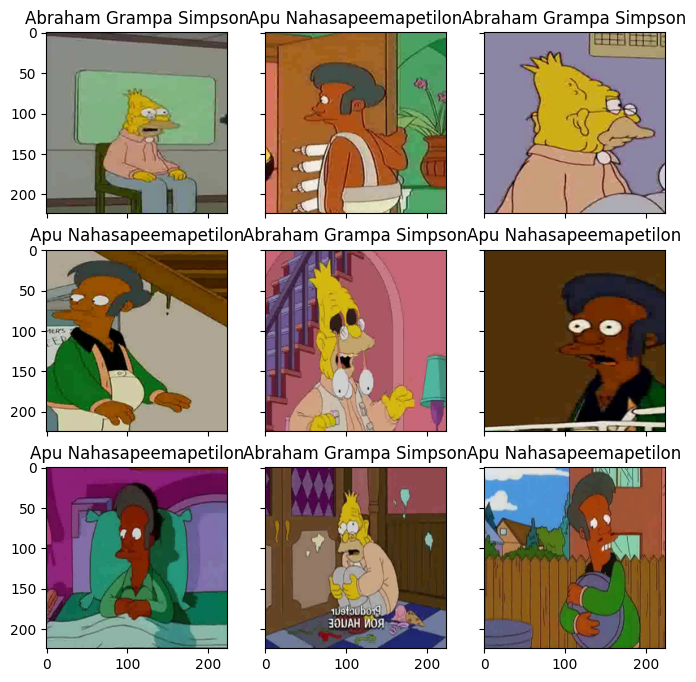

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [15]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader, desc='\ttrain', position=0):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader, desc='\tval', position=0):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [17]:
def train(train_files, val_files, model, epochs, batch_size,
          opt, criterion, scheduler):

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, pin_memory=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=True, pin_memory=True, num_workers=2)
    history = []
    log_template = "\n\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}\n"

    with tqdm(desc="epoch", total=epochs, position=0) as pbar_outer:
        max_acc = 0
        for epoch in range(epochs):

            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            scheduler.step()
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,
                                           v_loss=val_loss, t_acc=train_acc,
                                           v_acc=val_acc))
            if max_acc < val_acc:
                max_acc = val_acc
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    },
                           'checkpoint.pt')

    return history

In [18]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [19]:
from torchvision import models
#models.list_models()

In [20]:
model = models.mobilenet_v3_large(weights='DEFAULT').to(DEVICE)

In [21]:
#model.classifier

In [22]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=500, bias=True),
    nn.LeakyReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=500, out_features=42, bias=True),
).to(DEVICE)

In [23]:
#model

In [24]:
for param in list(model.parameters())[:-50]:
    param.requires_grad = False

In [25]:
for param in list(model.parameters())[-51:]:
    print(param.requires_grad)
print(len(list(model.parameters())))

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
174


Запустим обучение сети.

In [26]:
if exists('checkpoint.pt'):
    checkpoint = torch.load('checkpoint.pt', map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3,
                                                gamma=0.5)
    loss_fn = nn.CrossEntropyLoss()

else:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
                                 weight_decay=1e-5)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7,
                                                gamma=0.2)

In [27]:
start_time = time()
history = train(train_dataset, val_dataset, model=model, epochs=5,
                batch_size=16, opt=optimizer, scheduler=scheduler,
                criterion=loss_fn,)
print('Execution time is {:2.2f} minutes'.format((time() - start_time)/60))

	train: 100%|██████████| 982/982 [01:30<00:00, 10.81it/s]


loss 0.10103488556862672


epoch:  20%|██        | 1/5 [01:57<07:48, 117.23s/it]



Epoch 001 train_loss: 0.1010     val_loss 0.2633 train_acc 0.9818 val_acc 0.9832



	train: 100%|██████████| 982/982 [01:29<00:00, 11.03it/s]


loss 0.14503692825958944


epoch:  40%|████      | 2/5 [03:52<05:48, 116.22s/it]



Epoch 002 train_loss: 0.1450     val_loss 0.1908 train_acc 0.9686 val_acc 0.9817



	train: 100%|██████████| 982/982 [01:27<00:00, 11.22it/s]


loss 0.153857720408811


epoch:  60%|██████    | 3/5 [05:46<03:50, 115.21s/it]



Epoch 003 train_loss: 0.1539     val_loss 0.1708 train_acc 0.9657 val_acc 0.9773



	train: 100%|██████████| 982/982 [01:29<00:00, 11.02it/s]


loss 0.137746458668486


epoch:  80%|████████  | 4/5 [07:42<01:55, 115.36s/it]



Epoch 004 train_loss: 0.1377     val_loss 0.1032 train_acc 0.9697 val_acc 0.9790



	train: 100%|██████████| 982/982 [01:27<00:00, 11.16it/s]


loss 0.1215171631214664


epoch: 100%|██████████| 5/5 [09:36<00:00, 115.27s/it]



Epoch 005 train_loss: 0.1215     val_loss 0.0957 train_acc 0.9739 val_acc 0.9801

Execution time is 9.61 minutes


Построим кривые обучения

In [28]:
loss, acc, val_loss, val_acc = zip(*history)

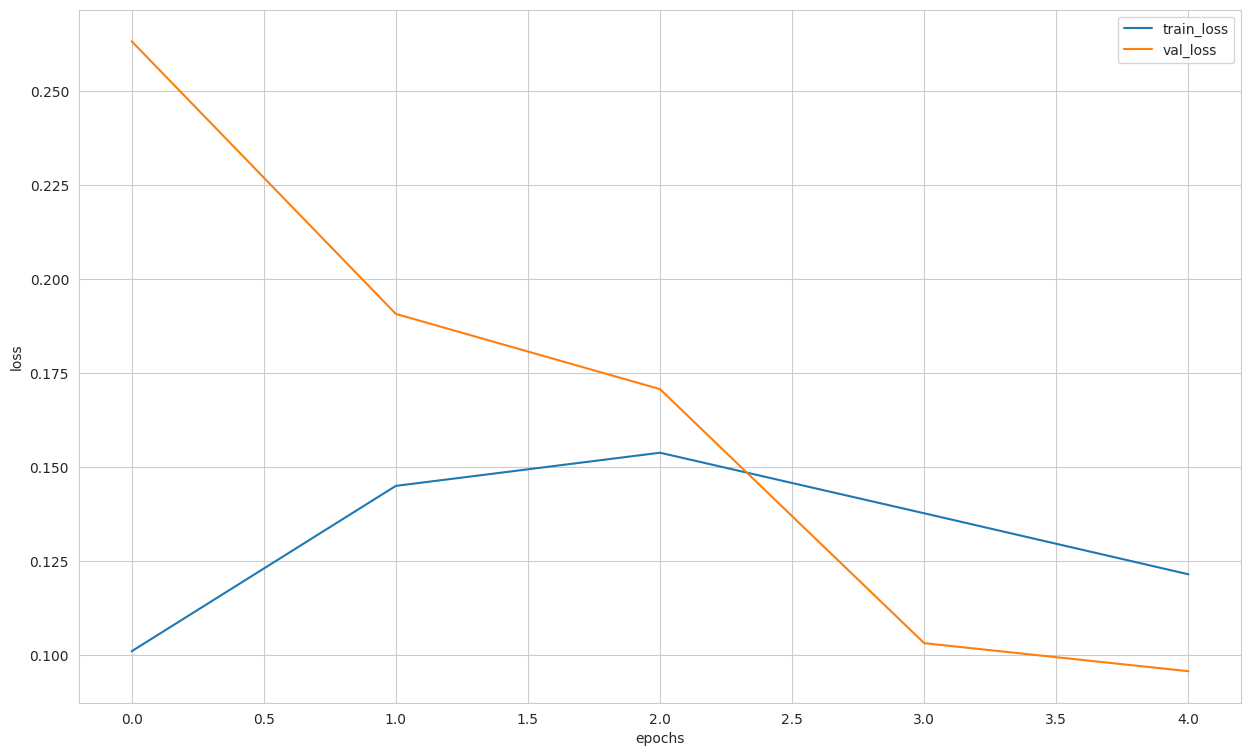

In [29]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [52]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).to(device)
        probs = torch.nn.functional.softmax(logit, dim=-1).cpu().numpy()
    return probs

In [31]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model.cpu(), ex_img.unsqueeze(0), device='cpu')

In [32]:
imgs = [sample[0].unsqueeze(0).cpu() for sample in tqdm(val_dataset)]

100%|██████████| 5234/5234 [00:31<00:00, 167.04it/s]


In [36]:
model.eval()
probs_ims = predict(model.to('cuda'), list(imgs))

In [37]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
y_pred = np.argmax(probs_ims,-1)
actual_labels = [sample[1] for sample in tqdm(val_dataset, position=0)]
actual_labels = label_encoder.inverse_transform(actual_labels)
preds_class = [label_encoder.classes_[i] for i in y_pred]

100%|██████████| 5234/5234 [00:30<00:00, 171.73it/s]


Вычислим f1-score на валидационной выборке.

In [40]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='weighted')

0.979276447220639

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

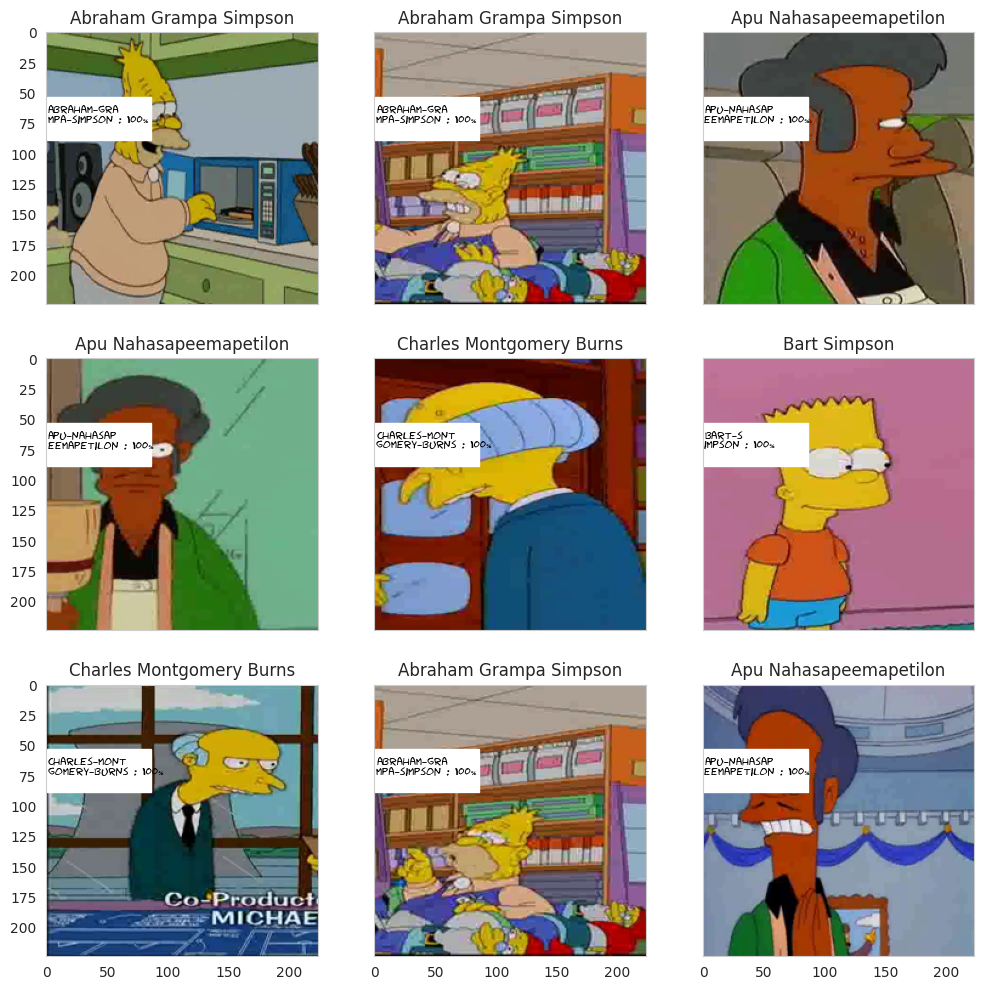

In [54]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model.cuda(), im_val.unsqueeze(0), device=DEVICE)
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [55]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [56]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames,
                          'Expected': preds})

In [57]:
my_submit.to_csv('/content/simple_cnn_baseline.csv',
                 index=False)

##Результат - F1 = 0.98